# Segmentation de lésions pulmonaires

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


from tqdm.notebook import tqdm
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import random
import cv2
import shutil


import tensorflow as tf
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from keras.models import Model
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

width=256
height=256
input_shape = (width, height, 1)

### mettre les paths en dataframe

In [7]:
path_frames = "./images/frames/"
path_masks = "./images/masks/"

frames = [os.path.join(path_frames, i) for i in os.listdir(path_frames)]
masks = [os.path.join(path_masks, i) for i in os.listdir(path_masks)]
data = pd.DataFrame(list(zip(frames, masks)), columns=['frames', 'masks'])

### Créer des jeux de train, test, validation (par path)

In [8]:
# création de jeux de train, test, validation

X_a_sep, X_test, y_a_sep, y_test = train_test_split(data['frames'], data['masks'], random_state=3, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_a_sep, y_a_sep, random_state=3, test_size=0.1)

In [9]:
X_train = X_train.reindex() 
y_train = y_train.reindex()
X_test = X_test.reindex()
y_test = y_test.reindex()
X_val = X_val.reindex()
y_val = y_val.reindex()

In [2]:
# couper-coller les photos dans des dossiers distincts 

# os.makedirs('./train/frames')
# os.makedirs('./train/masks')
# os.makedirs('./val/frames')
# os.makedirs('./val/masks')
# os.makedirs('./test/frames')
# os.makedirs('./test/masks')

# for i in range(X_train.shape[0]):
#     shutil.move(X_train.iloc[i], './train/frames')
#     shutil.move(y_train.iloc[i], './train/masks')

# for i in range(X_test.shape[0]):
#     shutil.move(X_test.iloc[i], './test/frames')
#     shutil.move(y_test.iloc[i], './test/masks')

# for i in range(X_val.shape[0]):
#     shutil.move(X_val.iloc[i], './val/frames')
#     shutil.move(y_val.iloc[i], './val/masks')       

SI l'entraînement est fait sur Google Colab, importer les dossier dans google drive, exécuter le bout de code suivant et changer les chemins des dossiers
> from google.colab import drive    
> drive.mount('/content/drive')

## import des images

In [3]:
dir_train = "./train/"
dir_test = "./test/"


dir_img = "/content/drive/MyDrive/train/frames/"
dir_mask= "/content/drive/MyDrive/train/masks/"
tab_img=[]
tab_mask=[]

# Récupération de la liste des fichiers images
files = os.listdir(dir_img)
# Mélange des images 

for n, i in tqdm(enumerate(files), total=len(files)):

    tab_img.append(cv2.resize(cv2.imread(dir_img+i), (width, height))/255)

    img_mask=cv2.resize(cv2.imread(dir_mask+i), (width, height))[:,:,2]
    img_mask_result=np.zeros(shape=(height, width, 1), dtype=np.float32)  # Image vide (h,w, N) avec N = nombre de classes
    img_mask_result[:,:,0][img_mask==255]=1.  ## Pour toutes les h,w de la profondeur 0 : Quand Couleur 255 (blanc) => Classe 1
    tab_mask.append(img_mask_result)

# Préparation du Tenseur
tab_img=np.array(tab_img)
tab_mask=np.array(tab_mask)
X_train = tab_img.copy()
y_train = tab_mask.copy()

In [ ]:
dir_img = "/content/drive/MyDrive/test/frames/"
dir_mask= "/content/drive/MyDrive/test/masks/"
tab_img=[]
tab_mask=[]

# Récupération de la liste des fichiers images
files = os.listdir(dir_img)

for n, i in tqdm(enumerate(files), total=len(files)):

    tab_img.append(cv2.resize(cv2.imread(dir_img+i), (width, height))/255)

    img_mask=cv2.resize(cv2.imread(dir_mask+i), (width, height))[:,:,2]
    img_mask_result=np.zeros(shape=(height, width, 1), dtype=np.float32)  # Image vide (h,w, N) avec N = nombre de classes
    img_mask_result[:,:,0][img_mask==255]=1.  ## Pour toutes les h,w de la profondeur 0 : Quand Couleur 255 (blanc) => Classe 1
    tab_mask.append(img_mask_result)

# Préparation du Tenseur
tab_img=np.array(tab_img)
tab_mask=np.array(tab_mask)
X_test = tab_img.copy()
y_test = tab_mask.copy()

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

### Data-augmentation

In [ ]:
# Creating the training Image and Mask generator
image_datagen = ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')
mask_datagen = ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')



# Apprentissage (+ standardisation)
seed = 42
image_datagen.fit(X_train, augment=True, seed=seed)
mask_datagen.fit(y_train, augment=True, seed=seed)

# Application de la Data Augmentation
BATCH_SIZE = 32
x=image_datagen.flow(X_train,batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y=mask_datagen.flow(y_train,batch_size=BATCH_SIZE,shuffle=True, seed=seed)


# Creating the validation Image and Mask generator
image_datagen_test = ImageDataGenerator()
mask_datagen_test = ImageDataGenerator()

image_datagen_test.fit(X_test, augment=True, seed=seed)
mask_datagen_test.fit(y_test, augment=True, seed=seed)

x_val=image_datagen_test.flow(X_test,batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y_val=mask_datagen_test.flow(y_test,batch_size=BATCH_SIZE,shuffle=True, seed=seed)

#creating a training and validation generator that generate masks and images
train_generator = zip(x, y)
val_generator = zip(x_val, y_val)

### Affichage d'une image et de son masque

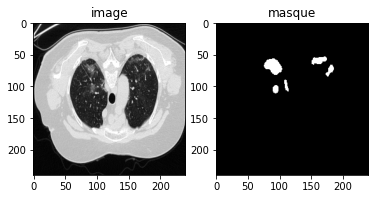

In [6]:
ind = random.randint(0, X_train.shape[0])

plt.subplot(1, 2, 1)
plt.title('image')
plt.imshow(X_train[ind,:,:,:], cmap='gray')

plt.subplot(1, 2, 2)
plt.title('masque')
plt.imshow(y_train[ind,:,:, 0], cmap='gray')

### Import bibliothèque unet

In [ ]:
!pip install -Uq segmentation-models

### Compilation du modèle

In [ ]:
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

from segmentation_models import Unet

model = Unet('resnet34', encoder_weights='imagenet', classes=1, input_shape=input_shape, activation='sigmoid')

metrics=["acc", tf.keras.metrics.Recall(),tf.keras.metrics.Precision(), sm.metrics.FScore(threshold=0.5)]

model.compile('Adam', loss="binary_crossentropy", metrics=metrics)

callbacks = [
    ModelCheckpoint('unet2.h5', save_best_only=True),
    ReduceLROnPlateau()
]

### Entraînement du modèle

> Réalisé sur google colab avec GPU 

In [1]:
EPOCHS = 2

results = model.fit(train_generator,
                    steps_per_epoch=1000,
                    epochs=EPOCHS,
                    validation_data=val_generator,
                    validation_steps=500, 
                    callbacks=callbacks
                    )

### Evaluation du modèle (graphiques)

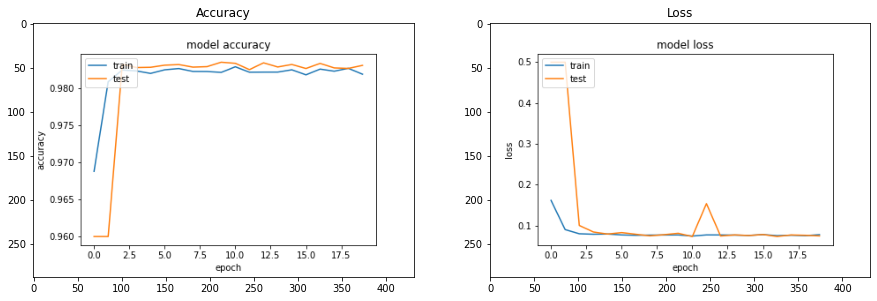

In [5]:
import pandas as pd

# enregistrement des métriques en csv
pd.DataFrame(results.history).to_csv('history.csv', index=False)

# affichage des courbes
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('./images2/acc.png')

plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('./images2/loss.png')


plt.plot(results.history['f1-score'])
plt.plot(results.history['val_f1-score'])
plt.title('model f1 score')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('./images2/f1.png')

plt.plot(results.history['val_recall'])
plt.plot(results.history['val_precision'])
plt.title('recall - precision')
plt.ylabel('métriques')
plt.xlabel('epoch')
plt.legend(['recall', 'précision'], loc='upper left')
plt.savefig('./images2/recallprecision.png')



plt.figure(figsize=(15,7))

plt.subplot(1, 2, 1)
plt.title('Accuracy')
acc = plt.imread('./images2/acc.png')
plt.imshow(acc)

plt.subplot(1, 2, 2)
plt.title('Loss')
loss = plt.imread('./images2/loss.png')
plt.imshow(loss)

plt.subplot(1, 2, 3)
plt.title('f1 score')
f1 = plt.imread('./images2/f1.png')
plt.imshow(f1)

plt.subplot(1, 2, 4)
plt.title('balance recall précision')
recallprecision = plt.imread('./images2/recallprecision.png')
plt.imshow(recallprecision)

## Prédictions

In [4]:
from keras.models import model_from_json
json_file = open('./models/model.json', 'r')
model = json_file.read()
json_file.close()
model = model_from_json(model)
# load weights into new model
model.load_weights("./models/model.h5")
print("Loaded model from disk")

2022-06-15 15:00:24.846469: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-06-15 15:00:24.846512: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (erwan-ThinkPad-T460s): /proc/driver/nvidia/version does not exist
2022-06-15 15:00:24.847044: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loaded model from disk


1/1 [==============================] - 0s 337ms/step


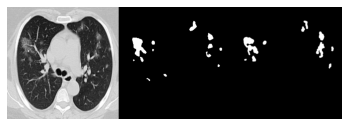

In [14]:
from PIL import Image

imtest = "./val/frames/bjorke_5.png"
immask = "./val/masks/bjorke_5.png"




raw = Image.open(imtest)

raw = np.array(raw.resize((width, height)))/255.
raw2 = Image.open(immask)
raw2 = np.array(raw2.resize((width, height)))/255.
raw = raw[:,:,0:3]

#predict the mask
pred = model.predict(np.expand_dims(raw, 0))

#mask post-processing
msk = pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)
msk[msk >= 0.5] = 1
msk[msk < 0.5] = 0

#show the mask and the segmented image
combined = np.concatenate([raw, msk, raw2], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.savefig('./images2/pred.png', dpi = 300, bbox_inches='tight')
plt.show()